In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import sklearn.metrics

In [2]:
# Function to plot the elbow graph to determine the optimal number of clusters.

from sklearn.cluster import KMeans

def plot_distortion(X,max_clusters = 7):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.title('Change in Intra-Cluster Distance with Increasing Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Intra-Cluster Distance')
    plt.show()

In [3]:
# Function to plot clusters based on 2 components PCAs.

import matplotlib.pyplot as plt

def plot_clusters(principalDf):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('Clustering based on 2 component PCA', fontsize = 20)
    targets = [0,1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cluster'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal_component_1'], principalDf.loc[indicesToKeep, 'principal_component_2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()

In [4]:
# Function to plot DBSCAN clusters.

def plot_clusters_DBSCAN(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# read all real estate features (both numeric and textual).

df_train = pd.read_csv('./Cleaned_Data/train_nlp_v00.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83049 entries, 0 to 83048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      83049 non-null  int64  
 1   id              83049 non-null  int64  
 2   locationId      83049 non-null  int64  
 3   regionId        83049 non-null  int64  
 4   provinceId      83049 non-null  int64  
 5   countryId       83049 non-null  int64  
 6   typeId          83049 non-null  int64  
 7   price           76873 non-null  float64
 8   rooms           8486 non-null   float64
 9   bedrooms        70207 non-null  float64
 10  bathrooms       68227 non-null  float64
 11  totalArea       56709 non-null  float64
 12  livingArea      30921 non-null  float64
 13  plotArea        44257 non-null  float64
 14  terraceArea     17130 non-null  float64
 15  text_processed  82836 non-null  object 
dtypes: float64(8), int64(7), object(1)
memory usage: 10.1+ MB


In [7]:
df_train.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df_train[df_train['text_processed'].isna()]

,id,locationId,regionId,provinceId,countryId,typeId,price,rooms,bedrooms,bathrooms,totalArea,livingArea,plotArea,terraceArea,text_processed
849,1020,27,3,2,1,2,4950000.0,NaN,6.0,7.0,NaN,1008.0,1400.0,232.0,NaN
1078,1312,97,269,2,1,2,4250000.0,7.0,4.0,NaN,NaN,646.0,2000.0,150.0,NaN
2141,2573,67,8,2,1,2,2680000.0,6.0,3.0,NaN,NaN,648.0,14000.0,NaN,NaN
4590,5698,15,3,2,1,2,990000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5740,7100,65,7,2,1,2,300000.0,NaN,NaN,NaN,NaN,150.0,50000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81675,103224,27,3,2,1,2,1400000.0,NaN,4.0,4.0,NaN,280.0,NaN,60.0,NaN
82558,104432,139,132,131,130,1,850000.0,NaN,1.0,1.0,NaN,73.0,NaN,13.0,NaN
82559,104433,135,132,131,130,1,915000.0,NaN,2.0,2.0,NaN,128.0,NaN,88.0,NaN
82707,104639,48,5,2,1,4,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN


In [9]:
# Drop rows with null text feature values.

df_train.drop(df_train[df_train['text_processed'].isna()].index.tolist(), inplace=True)

# Drop extraneous columns.

df_train.drop(columns=['id','locationId','regionId','provinceId','countryId'], inplace=True)

# Drop rows with housing types other than 'housing' and 'apartment'.

df_train.drop(df_train[df_train['typeId']==3].index.tolist(), inplace=True)

df_train.drop(df_train[df_train['typeId']==4].index.tolist(), inplace=True)

df_train.drop(df_train[df_train['typeId']==5].index.tolist(), inplace=True)

# Reset dataframe index.

df_train.reset_index(inplace=True)

# # Convert the housing types into 0 and 1.

df_train['typeId'][df_train['typeId']==1] = 0

df_train['typeId'][df_train['typeId']==2] = 1

In [17]:
# Vectorize the text features as per TFID Vectorizer.

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(max_features=5000).fit_transform(df_train['text_processed'])

type(vec)

scipy.sparse._csr.csr_matrix

In [18]:
vec.shape

(74906, 5000)

In [19]:
df_text_vectorized = pd.DataFrame(vec.toarray())

In [20]:
df_text_vectorized

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_train.drop(columns=['text_processed'], inplace=True)

In [22]:
df_train

,index,typeId,price,rooms,bedrooms,bathrooms,totalArea,livingArea,plotArea,terraceArea
0,0,1,26500000.0,20.0,10.0,16.0,4000.0,2800.0,820000.0,NaN
1,1,1,26500000.0,NaN,10.0,12.0,3000.0,NaN,1200000.0,NaN
2,2,1,26500000.0,NaN,10.0,12.0,3000.0,NaN,NaN,NaN
3,3,1,26500000.0,NaN,10.0,12.0,3000.0,NaN,1200000.0,NaN
4,4,1,26500000.0,NaN,10.0,12.0,NaN,NaN,1200000.0,NaN
...,...,...,...,...,...,...,...,...,...,...
74901,83044,0,315000.0,NaN,2.0,2.0,140.0,110.0,NaN,30.0
74902,83045,0,310000.0,NaN,3.0,2.0,88.0,88.0,NaN,NaN
74903,83046,1,310000.0,NaN,3.0,1.0,85.0,NaN,NaN,NaN
74904,83047,0,NaN,NaN,4.0,3.0,NaN,120.0,NaN,NaN


In [23]:
df_train.drop(columns=['index'], inplace=True)

In [24]:
# Fill the null feature values with mean values of the respective housing type category.

df_train['price'].mask((df_train['price'].isna()) & (df_train['typeId'] == 0), other=df_train['price'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['price'].mask((df_train['price'].isna()) & (df_train['typeId'] == 1), other=df_train['price'][df_train['typeId'] == 1].median().round(0), inplace=True)

df_train['rooms'].mask((df_train['rooms'].isna()) & (df_train['typeId'] == 0), other=df_train['rooms'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['rooms'].mask((df_train['rooms'].isna()) & (df_train['typeId'] == 1), other=df_train['rooms'][df_train['typeId'] == 1].median().round(0), inplace=True)

df_train['bedrooms'].mask((df_train['bedrooms'].isna()) & (df_train['typeId'] == 0), other=df_train['bedrooms'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['bedrooms'].mask((df_train['bedrooms'].isna()) & (df_train['typeId'] == 1), other=df_train['bedrooms'][df_train['typeId'] == 1].median().round(0), inplace=True)

df_train['bathrooms'].mask((df_train['bathrooms'].isna()) & (df_train['typeId'] == 0), other=df_train['bathrooms'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['bathrooms'].mask((df_train['bathrooms'].isna()) & (df_train['typeId'] == 1), other=df_train['bathrooms'][df_train['typeId'] == 1].median().round(0), inplace=True)

df_train['totalArea'].mask((df_train['totalArea'].isna()) & (df_train['typeId'] == 0), other=df_train['totalArea'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['totalArea'].mask((df_train['totalArea'].isna()) & (df_train['typeId'] == 1), other=df_train['totalArea'][df_train['typeId'] == 1].median().round(0), inplace=True)

df_train['livingArea'].mask((df_train['livingArea'].isna()) & (df_train['typeId'] == 0), other=df_train['livingArea'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['livingArea'].mask((df_train['livingArea'].isna()) & (df_train['typeId'] == 1), other=df_train['livingArea'][df_train['typeId'] == 1].median().round(0), inplace=True)

df_train['plotArea'].mask((df_train['plotArea'].isna()) & (df_train['typeId'] == 0), other=df_train['plotArea'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['plotArea'].mask((df_train['plotArea'].isna()) & (df_train['typeId'] == 1), other=df_train['plotArea'][df_train['typeId'] == 1].median().round(0), inplace=True)

df_train['terraceArea'].mask((df_train['terraceArea'].isna()) & (df_train['typeId'] == 0), other=df_train['terraceArea'][df_train['typeId'] == 0].median().round(0), inplace=True)
df_train['terraceArea'].mask((df_train['terraceArea'].isna()) & (df_train['typeId'] == 1), other=df_train['terraceArea'][df_train['typeId'] == 1].median().round(0), inplace=True)

In [25]:
df_type = pd.DataFrame(df_train['typeId'])

In [26]:
df_train.drop(columns=['typeId'], inplace=True)

In [27]:
df_type

,typeId
0,1
1,1
2,1
3,1
4,1
...,...
74901,0
74902,0
74903,1
74904,0


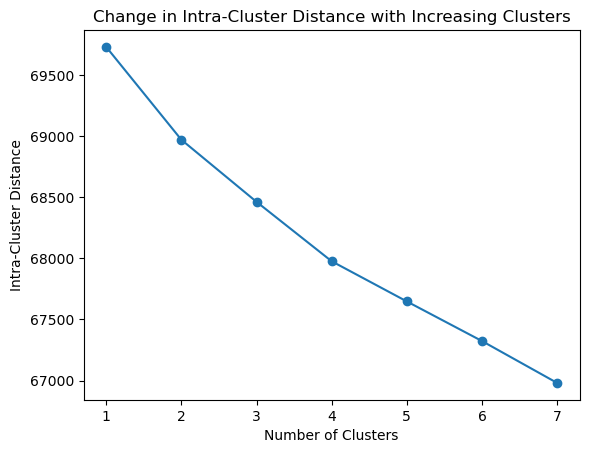

In [118]:
# plot elbow chart with only text features. There is no apparent clustering in the data.

plot_distortion(df_text_vectorized)

In [28]:
# Scale the numeric data.

from sklearn.preprocessing import MinMaxScaler

df_train = pd.DataFrame(MinMaxScaler().fit_transform(df_train.iloc[:,0:8]), columns=['price', 'rooms', 'bedrooms', 'bathrooms', 'totalArea', 'livingArea', 'plotArea', 'terraceArea'])

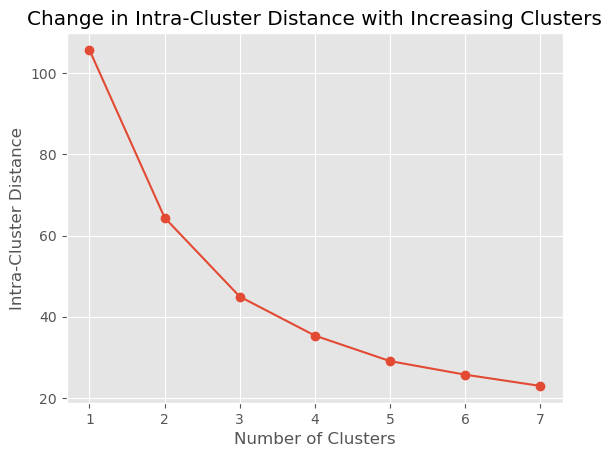

In [163]:
# plot elbow chart with numeric features only. Some clustering is visible.

plot_distortion(df_train)

In [29]:
# Perform PCA decomposition with 85% variance.

from sklearn.decomposition import PCA

pca = PCA(n_components=0.85)
principalComponents = pca.fit_transform(df_train)

In [30]:
# publish the number of PCA components deduced. 

pca.n_components_

2

In [31]:
# publish the total variance achieved.

pca.explained_variance_ratio_

array([0.61230723, 0.29433378])

In [32]:
# find the values of principal DF components.

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal_component_1', 'principal_component_2'])

# choosing 2 clusters and applying fit and predict algorithm from kmeans.
principalDf['cluster'] = KMeans(n_clusters=2, n_init=10, random_state=42).fit_predict(principalDf)

principalDf = principalDf.join(df_type)

In [33]:
principalDf['cluster'].value_counts()

0    45161
1    29745
Name: cluster, dtype: int64

In [34]:
# it is clear that the dataset is successfully being clustered around housing types.

principalDf[(principalDf['typeId']==0) & (principalDf['cluster']==1)].count()

principal_component_1    28188
principal_component_2    28188
cluster                  28188
typeId                   28188
dtype: int64

In [35]:
principalDf[(principalDf['typeId']==1) & (principalDf['cluster']==0)].count()

principal_component_1    44577
principal_component_2    44577
cluster                  44577
typeId                   44577
dtype: int64

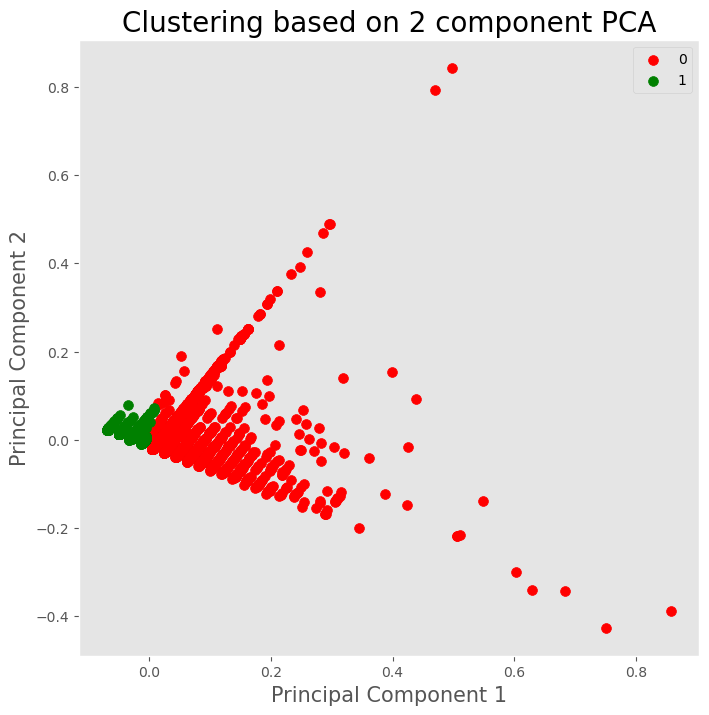

In [243]:
plot_clusters(principalDf)

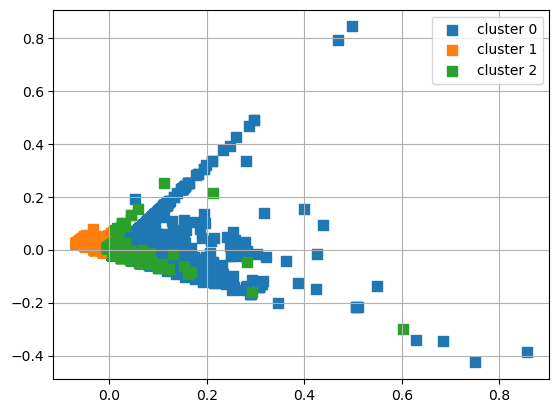

In [38]:
# use DBSCAN clustering. DBSCAN creates 3 clusters. one for apartment, another for houses and a third category 
# for large apartments/small houses.

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1,
            min_samples=12,
            metric='euclidean')

# fit and predicr
y_db = db.fit_predict(principalDf.to_numpy())

# Plot DBSCAN clusters
plot_clusters_DBSCAN(principalDf.to_numpy(),y_db)

In [40]:
pd.DataFrame(y_db).value_counts()

0    44577
1    29745
2      584
dtype: int64

In [295]:
df_train = df_train.join(df_text_vectorized)

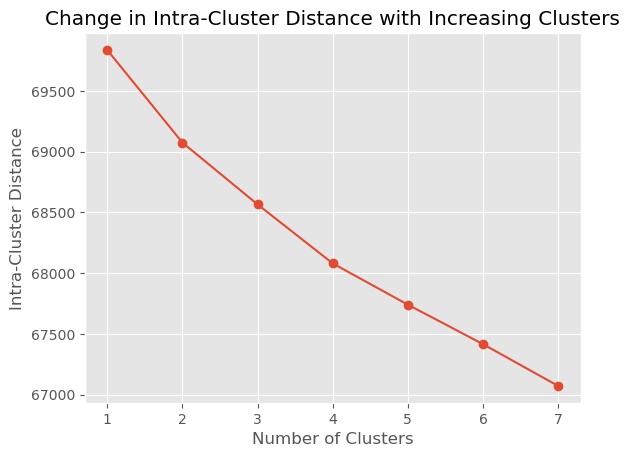

In [172]:
# elbow chart with only text features doesn't yield clear clustering pattern. 

plot_distortion(df_train.to_numpy())

In [238]:
df_train = pd.DataFrame(df_train.iloc[:,0:8], columns=['price', 'rooms', 'bedrooms', 'bathrooms', 'totalArea', 'livingArea', 'plotArea', 'terraceArea']).join(df_type)

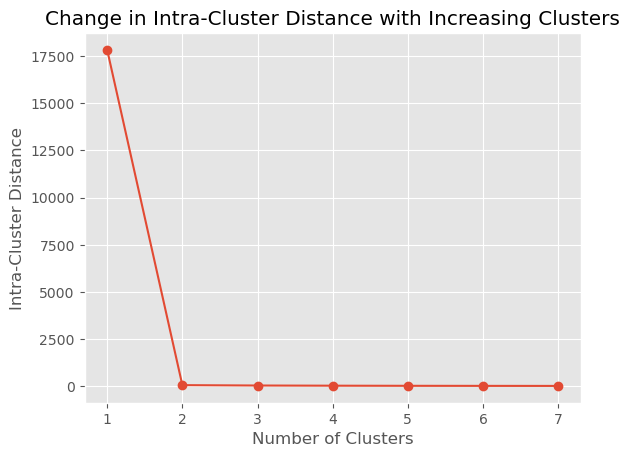

In [240]:
# elbow chart with only numeric features shows clear 2 clusters (for house and apartments).

plot_distortion(df_train)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.85)
principalComponents = pca.fit_transform(df_train)

In [ ]:
pca.n_components_

2

In [ ]:
pca.explained_variance_ratio_

array([0.61230723, 0.29433378])

In [255]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.85)
principalComponents = pca.fit_transform(df_train)

In [256]:
pca.n_components_

1

In [257]:
pca.explained_variance_ratio_

array([0.99617864])

In [259]:
principalDf_2 = pd.DataFrame(data = principalComponents, columns = ['principal_component_1'])

# choosing 2 clusters and applying fit and predict algorithm from kmeans.
principalDf_2['cluster'] = KMeans(n_clusters=2, n_init=10, random_state=42).fit_predict(principalDf_2)

principalDf_2 = principalDf_2.join(df_type)

In [261]:
principalDf_2['cluster'].value_counts()

0    46134
1    28772
Name: cluster, dtype: int64

In [262]:
principalDf_2[(principalDf_2['typeId']==0) & (principalDf_2['cluster']==1)].count()

principal_component_1    28772
cluster                  28772
typeId                   28772
dtype: int64

In [263]:
principalDf_2[(principalDf_2['typeId']==1) & (principalDf_2['cluster']==0)].count()

principal_component_1    46134
cluster                  46134
typeId                   46134
dtype: int64

In [265]:
df_train

,price,rooms,bedrooms,bathrooms,totalArea,livingArea,plotArea,terraceArea,typeId
0,0.311761,0.404255,0.022556,0.037594,0.011676,0.003144,0.020500,0.000041,1
1,0.311761,0.085106,0.022556,0.027569,0.008742,0.000322,0.030000,0.000041,1
2,0.311761,0.085106,0.022556,0.027569,0.008742,0.000322,0.000036,0.000041,1
3,0.311761,0.085106,0.022556,0.027569,0.008742,0.000322,0.030000,0.000041,1
4,0.311761,0.085106,0.022556,0.027569,0.000880,0.000322,0.030000,0.000041,1
...,...,...,...,...,...,...,...,...,...
74901,0.003701,0.042553,0.002506,0.002506,0.000352,0.000102,0.000003,0.000012,0
74902,0.003642,0.042553,0.005013,0.002506,0.000199,0.000077,0.000003,0.000011,0
74903,0.003642,0.085106,0.005013,0.000000,0.000191,0.000322,0.000036,0.000041,1
74904,0.004018,0.042553,0.007519,0.005013,0.000276,0.000113,0.000003,0.000011,0
